In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import pdist
from nms import nms
from config_voting import *
from copy import *
%matplotlib inline


file_path = '/export/home/qliu24/qing_voting_data/intermediate/feat_pickle_VGG/'

oo = 'car'
fname = file_path + 'res_info_' + oo + '_train_carVC.pickle'
print('loading object {0}'.format(oo))
with open(fname, 'rb') as fh:
    layer_feature_dist, _, view_point = pickle.load(fh)
            
N = len(layer_feature_dist)
print('total number of instances {0}'.format(N))

view_point = np.array(view_point)
idx_s = np.where(np.logical_and(view_point>=67.5,view_point<=112.5))[0]

layer_feature_dist = [layer_feature_dist[nn] for nn in idx_s]

N = len(layer_feature_dist)
print('total number of instances {0}'.format(N))

'''
# load original pool4 features
file_cache_feat = '/export/home/qliu24/qing_voting_data/intermediate/feat_VGG/car_mergelist_rand_train_carVC.pickle'
with open(file_cache_feat, 'rb') as fh:
    feat_set, layer_feature_dist = pickle.load(fh)
'''   

magic_thh = 0.85
layer_feature_b = [None for nn in range(N)]
for nn in range(N):
    layer_feature_b[nn] = (layer_feature_dist[nn]<magic_thh).astype(int)
    
for lfb in layer_feature_b:
    lfb[0:3, :, :] = 0
    lfb[-3:, :, :] = 0
    lfb[:, 0:3, :] = 0
    lfb[:, -3:, :] = 0
    
magic_thh2 = 0.81
layer_feature_b2 = [None for nn in range(N)]
for nn in range(N):
    layer_feature_b2[nn] = (layer_feature_dist[nn]<magic_thh).astype(int)
    
for lfb in layer_feature_b2:
    lfb[0:3, :, :] = 0
    lfb[-3:, :, :] = 0
    lfb[:, 0:3, :] = 0
    lfb[:, -3:, :] = 0
    

max_0 = max([lfb.shape[0] for lfb in layer_feature_b])
max_1 = max([lfb.shape[1] for lfb in layer_feature_b])
max_2 = max([lfb.shape[2] for lfb in layer_feature_b])

print(max_0, max_1, max_2)

'''
print(Astride, Arf, Apad)
layer_fire_nms = [np.zeros_like(layer_feature_b[nn]) for nn in range(N)]
for nn in range(N):
    for vc_i in range(max_2):
        ri, ci = np.where(layer_feature_b[nn][:,:,vc_i]==1)
        if ri.size==0:
            continue
        
        r_list = Astride * ri + Arf/2 - Apad
        c_list = Astride * ci + Arf/2 - Apad
        bb_loc = np.column_stack([c_list-Arf/2, r_list-Arf/2, c_list+Arf/2, r_list+Arf/2])
        det = layer_feature_dist[nn][ri,ci,vc_i]
        
        bb_loc_ = np.column_stack([bb_loc, -det])
        nms_list = nms(bb_loc_, 0.05)
        layer_fire_nms[nn][ri[nms_list], ci[nms_list], vc_i] = 1
        
'''

loading object car
total number of instances 1000
total number of instances 118
14 54 158


'\nprint(Astride, Arf, Apad)\nlayer_fire_nms = [np.zeros_like(layer_feature_b[nn]) for nn in range(N)]\nfor nn in range(N):\n    for vc_i in range(max_2):\n        ri, ci = np.where(layer_feature_b[nn][:,:,vc_i]==1)\n        if ri.size==0:\n            continue\n        \n        r_list = Astride * ri + Arf/2 - Apad\n        c_list = Astride * ci + Arf/2 - Apad\n        bb_loc = np.column_stack([c_list-Arf/2, r_list-Arf/2, c_list+Arf/2, r_list+Arf/2])\n        det = layer_feature_dist[nn][ri,ci,vc_i]\n        \n        bb_loc_ = np.column_stack([bb_loc, -det])\n        nms_list = nms(bb_loc_, 0.05)\n        layer_fire_nms[nn][ri[nms_list], ci[nms_list], vc_i] = 1\n        \n'

In [2]:
def get_fired_pos(layer_f_dist, layer_f_b, heat_map, vc_templates=None):
    max_0, max_1 = heat_map[0][0].shape
    max_2 = len(heat_map)
    heat_map_min = 1/(max_0*max_1)
    hm_BG_val = np.log(heat_map_min)
    
    total_score = 0
    total_score_details = np.zeros(3)
    layer_f_pos = [[[None for hmnn in range(len(heat_map[vc_i]))] for vc_i in range(max_2)] for lfd in layer_f_dist]
    
    for lfd_i,lfd in enumerate(layer_f_dist):
        lfb = layer_f_b[lfd_i]
        rll,cll = lfd.shape[0:2]
        diff_r = int((max_0-rll)/2)
        diff_c = int((max_1-cll)/2)
        
        for vc_i in range(max_2):
            for hmnn,hm in enumerate(heat_map[vc_i]):
                hm_ll = hm[diff_r:diff_r+rll,diff_c:diff_c+cll]
                
                ri, ci = np.where(np.logical_and(lfb[:,:,vc_i]==1,hm_ll[:,:]>0))
                if ri.size==0:
                    continue
                
                if vc_templates is None:
                    vc_tplt = np.ones((7,7))*1.3
                else:
                    vc_tplt = vc_templates[vc_i][hmnn]
                
                det = []
                det_details = []
                for pp in zip(ri,ci):
                    pp_dist = lfd[pp[0]-3:pp[0]+4,pp[1]-3:pp[1]+4, vc_i]
                    score1 = np.log(hm_ll[pp[0],pp[1]]) - hm_BG_val
                    score2 = (1.7*49-np.sum(pp_dist**2))/2
                    score3 = (np.sum((pp_dist - np.ones((7,7))*1.3)**2)-np.sum((pp_dist - vc_tplt)**2))
                    det.append(score1+score2+score3)
                    det_details.append([score1,score2,score3])
                    
                max_idx = np.argmax(det)
                
                layer_f_pos[lfd_i][vc_i][hmnn] = (ri[max_idx]+diff_r, ci[max_idx]+diff_c)
                total_score += det[max_idx]
                total_score_details += np.array(det_details[max_idx])
            
    return layer_f_pos, total_score/len(layer_f_dist), total_score_details/len(layer_f_dist)


def get_heatmap(layer_f_pos, max_0, max_1, max_2, pctl = None, blur=0.3, thrh = None):
    heat_map = [[np.zeros((max_0, max_1)) for hmnn in range(len(layer_f_pos[0][vc_i]))] for vc_i in range(max_2)]
    for vc_i in range(max_2):
        for hmnn in range(len(layer_f_pos[0][vc_i])):
            vc_p = []
            for lfp in layer_f_pos:
                if lfp[vc_i][hmnn] is not None:
                    vc_p.append(lfp[vc_i][hmnn])
            
            if len(vc_p)==0:
                print('empty vc_p for {0}_{1}'.format(vc_i, hmnn))
                continue
                
            heat_map[vc_i][hmnn] = init_heatmap(vc_p, max_0, max_1, pctl, blur, thrh)
            
    return heat_map

    
def get_vctplt(layer_f_pos, layer_f_dist, max_0, max_1):
    vc_templates = [[np.zeros((7,7,0)) for hmnn in range(len(layer_f_pos[0][vc_i]))] for vc_i in range(len(layer_f_pos[0]))]
    
    for lfp,lfd in zip(layer_f_pos, layer_f_dist):
        rll,cll = lfd.shape[0:2]
        diff_r = int((max_0-rll)/2)
        diff_c = int((max_1-cll)/2)
        
        for vc_i in range(lfd.shape[2]):
            for hmnn in range(len(lfp[vc_i])):
                if lfp[vc_i][hmnn] is None:
                    continue
                    
                ri,ci = lfp[vc_i][hmnn]
                rr = ri-diff_r
                cc = ci-diff_c
                patch_dist = lfd[rr-3:rr+4, cc-3:cc+4, vc_i].reshape(7,7,1)
                vc_templates[vc_i][hmnn] = np.concatenate([vc_templates[vc_i][hmnn], patch_dist], axis=2)
                
    for vc_i in range(layer_f_dist[0].shape[2]):
        for hmnn in range(len(layer_f_pos[0][vc_i])):
            vc_templates[vc_i][hmnn] = np.median(vc_templates[vc_i][hmnn], axis=2)
        
    return vc_templates


def init_heatmap(vc_p, max_0, max_1, pctl = None, blur=0.3, thrh = None):
    hm = np.zeros((max_0, max_1))
    for pp in vc_p:
        if blur is None:
            hm[pp[0],pp[1]]+=1
        else:
            hm[pp[0],pp[1]]+=1.0-blur
            hm[pp[0]-1:pp[0]+2,pp[1]-1:pp[1]+2]+=blur
            
    if pctl is None and thrh is None:
        thrh = 0
    elif not (pctl is None):
        thrh = np.percentile(hm[hm>0], pctl)
        
    hm[hm<=thrh]=0
    hm /= np.sum(hm)
    return hm


In [3]:
def gm_vc_pos(pos_ls, cluster_num):
    gm = GaussianMixture(n_components=cluster_num, covariance_type='full', \
                                  n_init=10, max_iter=1500)
    
    gm.fit(pos_ls)
    assignment = gm.predict(pos_ls)
    return gm, assignment


heat_map_init = [[] for vc_i in range(max_2)]
for vc_i in range(max_2):
    # print('VC idx: {0}'.format(vc_i), end=' ')
    vc_p = []
    for nn in range(N):
        vc_l = layer_feature_b[nn][:,:,vc_i]
        rnum, colnum = vc_l.shape
        diffr = int((max_0-rnum)/2)
        diffc = int((max_1-colnum)/2)
        row_i, col_i = np.where(vc_l==1)
        for pp in zip(row_i,col_i):
            vc_p.append((pp[0]+diffr,pp[1]+diffc))
                
    if len(vc_p)<N/2:
        continue
        
    vc_p=np.array(vc_p)
    K=4
    gm, assignment = gm_vc_pos(vc_p, K)
    while True:
        p_dist = pdist(gm.means_)
        if np.any(gm.weights_<0.5/K) or np.any(p_dist<7):
            K -= 1
            if K==1:
                gm = None
                assignment = np.zeros(vc_p.shape[0])
                break
            else:
                gm, assignment = gm_vc_pos(vc_p, K)
        else:
            break
            
    # print('final K: {0}'.format(K), flush='True')
    
    for kk in range(K):
        vc_p_kk = vc_p[assignment==kk]
        if len(vc_p_kk)<10:
            print('cluster too small {0}_{1}'.format(vc_i, kk))
            continue
            
        heat_map_init[vc_i].append(init_heatmap(vc_p_kk, max_0, max_1, 10, None, None))
        
    if vc_i%20==0:
        print(vc_i)
        
print(len(heat_map_init))

0
20
40
60
80
100
120
140
158


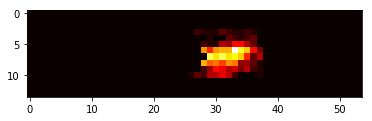

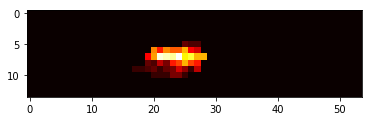

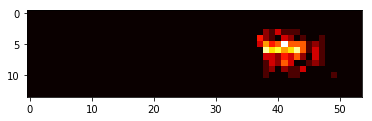

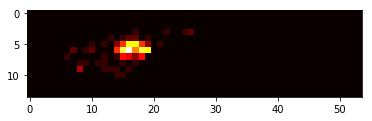

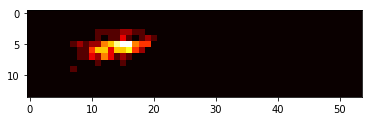

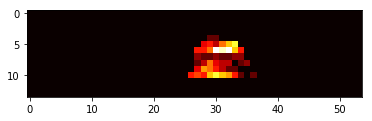

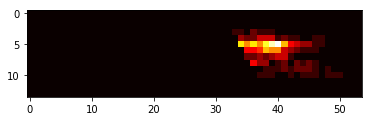

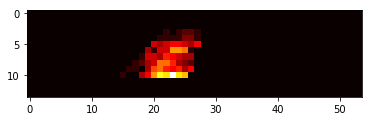

In [48]:
vc_i = 91
for hm in heat_map_init[vc_i]:
    plt.imshow(hm, cmap='hot', interpolation='nearest')
    plt.show()
    
vc_i = 109
for hm in heat_map_init[vc_i]:
    plt.imshow(hm, cmap='hot', interpolation='nearest')
    plt.show()


In [4]:
heat_map_min = 1/(max_0*max_1)
hm_BG_val = np.log(heat_map_min)
vc_templates = None
for vc_i in [0,1,65,143,91,109]:
    for hmnn in range(len(heat_map_init[vc_i])):
        stat1 = []
        stat2 = []
        stat3 = []
        for img_n in range(30):
            lfd = layer_feature_dist[img_n]
            lfb = layer_feature_b[img_n]
            rll,cll = lfd.shape[0:2]
            diff_r = int((max_0-rll)/2)
            diff_c = int((max_1-cll)/2)

            hm_ll = heat_map_init[vc_i][hmnn][diff_r:diff_r+rll,diff_c:diff_c+cll]
            ri, ci = np.where(np.logical_and(lfb[:,:,vc_i]==1,hm_ll[:,:]>0))
            if ri.size==0:
                continue

            if vc_templates is None:
                vc_tplt = np.ones((7,7))*1.3
            else:
                vc_tplt = vc_templates[vc_i][hmnn]

            det = []
            det_details = []
            for pp in zip(ri,ci):
                pp_dist = lfd[pp[0]-3:pp[0]+4,pp[1]-3:pp[1]+4, vc_i]
                score1 = np.log(hm_ll[pp[0],pp[1]]) - hm_BG_val
                score2 = (1.7*49-np.sum(pp_dist**2))/2
                score3 = (np.sum((pp_dist - np.ones((7,7))*1.3)**2)-np.sum((pp_dist - vc_tplt)**2))
                det.append(score1+score2+score3)
                det_details.append([score1,score2,score3])
                
            stat1.append(np.std(np.array(det_details)[:,0]))
            stat2.append(np.std(np.array(det_details)[:,1]))
            stat3.append(np.std(np.array(det_details)[:,2]))

        print(vc_i, hmnn, np.mean(stat1),np.mean(stat2),np.mean(stat3))
        

0 0 0.425729626352 0.417188153993 0.0
0 1 0.419853376336 0.569805870257 0.0
1 0 0.47566142739 0.431316660402 0.0
1 1 0.409434079832 0.421442037761 0.0
65 0 0.65156378172 0.977325810069 0.0
143 0 0.6041657214 0.621336053968 0.0
91 0 0.406084738397 0.313264939221 0.0
91 1 0.260228323837 0.281547082301 0.0
91 2 0.168361924309 0.153390110732 0.0
91 3 0.163205764166 0.0857301283278 0.0
109 0 0.147339743026 0.150465999243 0.0
109 1 0.0815507923019 0.0990605559214 0.0
109 2 0.284545526628 0.330421844054 0.0
109 3 0.212991002075 0.453080175364 0.0


In [5]:
layer_fired_pos, sc, sc_d = get_fired_pos(layer_feature_dist, layer_feature_b, heat_map_init)
print('iter {0} score: {1}, {2}'.format(-1, sc, sc_d))

for itt in range(5):
    vc_templates = get_vctplt(layer_fired_pos, layer_feature_dist, max_0, max_1)
    heat_map = get_heatmap(layer_fired_pos, max_0, max_1, max_2, blur=None, thrh = None)
    
    layer_fired_pos, sc, sc_d = get_fired_pos(layer_feature_dist, layer_feature_b, heat_map, vc_templates)
    print('iter {0} score: {1}, {2}'.format(itt, sc, sc_d))
    
heat_map = get_heatmap(layer_fired_pos, max_0, max_1, max_2, blur=0.5)

iter -1 score: 3713.007934452489, [  576.49734004  3136.51059441     0.        ]
iter 0 score: 4713.065158531312, [  672.13854644  3133.47679804   907.44981405]
iter 1 score: 4728.283269753881, [  690.57587324  3131.67401212   906.03338439]
iter 2 score: 4733.418350898234, [  697.16266213  3130.87690609   905.37878268]
iter 3 score: 4735.429447891682, [  699.68310422  3130.59440039   905.15194328]
iter 4 score: 4736.290852786917, [  700.90606768  3130.40401064   904.98077446]


In [7]:
for vc_i in [0,1,65,143,91,109]:
    for hmnn in range(len(heat_map[vc_i])):
        stat1 = []
        stat2 = []
        stat3 = []
        for img_n in range(30):
            lfd = layer_feature_dist[img_n]
            lfb = layer_feature_b[img_n]
            rll,cll = lfd.shape[0:2]
            diff_r = int((max_0-rll)/2)
            diff_c = int((max_1-cll)/2)

            hm_ll = heat_map[vc_i][hmnn][diff_r:diff_r+rll,diff_c:diff_c+cll]
            ri, ci = np.where(np.logical_and(lfb[:,:,vc_i]==1,hm_ll[:,:]>0))
            if ri.size==0:
                continue

            if vc_templates is None:
                vc_tplt = np.ones((7,7))*1.3
            else:
                vc_tplt = vc_templates[vc_i][hmnn]

            det = []
            det_details = []
            for pp in zip(ri,ci):
                pp_dist = lfd[pp[0]-3:pp[0]+4,pp[1]-3:pp[1]+4, vc_i]
                score1 = np.log(hm_ll[pp[0],pp[1]]) - hm_BG_val
                score2 = (1.7*49-np.sum(pp_dist**2))
                score3 = (np.sum((pp_dist - np.ones((7,7))*1.3)**2)-np.sum((pp_dist - vc_tplt)**2))
                det.append(score1+score2+score3)
                det_details.append([score1,score2,score3])
                
            stat1.append(np.std(np.array(det_details)[:,0]))
            stat2.append(np.std(np.array(det_details)[:,1]))
            stat3.append(np.std(np.array(det_details)[:,2]))

        print(vc_i, hmnn, np.mean(stat1),np.mean(stat2),np.mean(stat3))
        

0 0 0.74929256258 0.834195708578 0.52285772787
0 1 0.612030093858 1.12277456951 0.60156099458
1 0 0.772098488144 0.865985878207 0.559158146247
1 1 0.970691153583 0.835549361238 0.57513538251
65 0 0.950169666974 1.57340966979 0.606155331991
143 0 0.859062302535 1.11815797888 0.357748394143
91 0 0.777063625862 0.665813670779 0.233072129175
91 1 0.657198900894 0.687737555205 0.25130885571
91 2 0.48874184508 0.380790131828 0.128181363835
91 3 0.430292004202 0.510620400766 0.176039735025
109 0 0.24074307066 0.296215394654 0.0993249257515
109 1 0.179151388821 0.276956897215 0.0923020901466
109 2 0.543576557043 0.705461765862 0.252781243155
109 3 0.496532454902 0.847584035477 0.323688157034


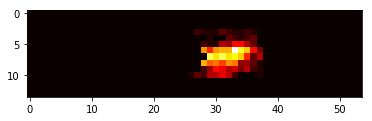

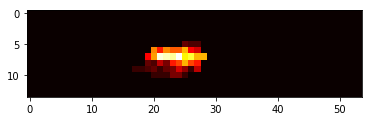

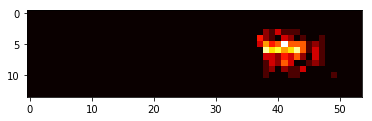

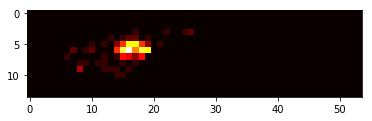

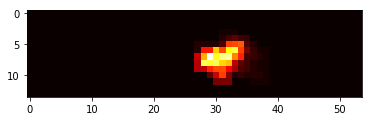

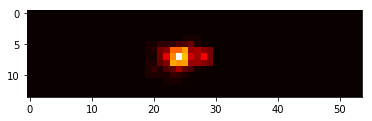

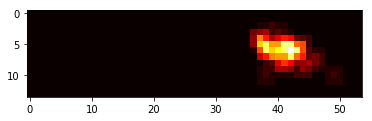

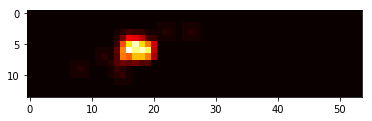

In [74]:
'''
vc_i = 91
for hm in heat_map_init[vc_i]:
    plt.imshow(hm, cmap='hot', interpolation='nearest')
    plt.show()
    
for hm in heat_map[vc_i]:
    plt.imshow(hm, cmap='hot', interpolation='nearest')
    plt.show()
    
'''    
vc_i = 91
for hm in heat_map_init[vc_i]:
    plt.imshow(hm, cmap='hot', interpolation='nearest')
    plt.show()
    
for hm in heat_map[vc_i]:
    plt.imshow(hm, cmap='hot', interpolation='nearest')
    plt.show()


In [40]:
51547.600068/(158*118)

2.76483587577773

In [53]:
(max_0-6)*(max_1-6)

384

In [43]:
np.sum(heat_map[0][1])

1.0

In [85]:
for vc_i in [65,143]:
    for hm in heat_map[vc_i]:
        hm_ll = hm.ravel()
        hm_ll = hm_ll[hm_ll!=0]
        print(vc_i, np.max(hm_ll), np.min(hm_ll), len(hm_ll), np.log(np.max(hm_ll)/np.min(hm_ll)))

65 0.157094594595 0.000788288288288 95 5.2947395452
143 0.158962264151 0.000825471698113 95 5.26046714242


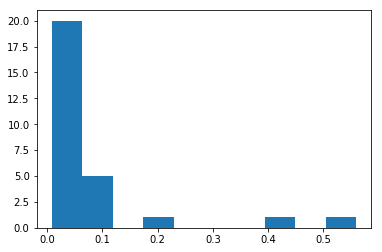

In [26]:
hm = heat_map[:,:,1].ravel()
hm = hm[hm!=0]
plt.hist(hm)
plt.show()

In [18]:
np.percentile(np.arange(10),1)

0.089999999999999997

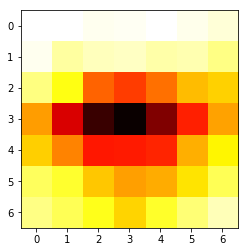

In [80]:
vc_i=143
for vct in vc_templates[vc_i]:
    plt.imshow(vct, cmap='hot', interpolation='nearest')
    plt.show()

In [161]:
vc_part_cnt = [[0 for hmnn in range(len(heat_map[vc_i]))] for vc_i in range(max_2)]

for vc_i in range(max_2):
    for hmnn in range(len(heat_map[vc_i])):
        for lfp in layer_fired_pos:
            if not(lfp[vc_i][hmnn] is None):
                vc_part_cnt[vc_i][hmnn] += 1

# np.sum([len(vpc)==0 for vpc in vc_part_cnt])
for vpc_i,vpc in enumerate(vc_part_cnt):
    if len(vpc)!=0:
        print(vpc_i,np.array(vpc)/N)

0 [ 0.96610169  0.95762712]
1 [ 0.94067797  0.98305085]
2 [ 0.96610169  0.95762712]
3 [ 0.33898305  0.43220339  0.36440678]
4 [ 0.94915254  0.94067797]
5 [ 0.91525424  0.97457627]
6 [ 0.97457627  0.94067797]
7 [ 0.92372881  0.96610169]
8 [ 1.          0.84745763]
9 [ 0.96610169  0.93220339  0.70338983]
10 [ 0.94067797]
11 [ 0.16101695  0.1779661 ]
12 [ 0.94915254  0.98305085]
13 [ 0.93220339  1.        ]
14 [ 1.]
15 [ 0.96610169  0.83050847]
16 [ 0.77118644  0.98305085]
18 [ 0.99152542]
19 [ 0.53389831  0.91525424  0.84745763]
20 [ 0.94067797]
21 [ 0.93220339  0.97457627]
22 [ 0.72033898  0.66949153]
23 [ 0.98305085]
24 [ 0.99152542  0.83050847]
25 [ 0.84745763  0.74576271]
26 [ 0.97457627  0.97457627]
27 [ 0.15254237  0.20338983]
28 [ 0.57627119]
29 [ 0.71186441  0.56779661]
31 [ 0.90677966  0.8220339 ]
32 [ 0.65254237  0.6440678 ]
33 [ 0.92372881]
34 [ 0.61864407  0.47457627]
35 [ 0.86440678  0.76271186  0.69491525]
36 [ 0.83898305  0.79661017]
37 [ 1.]
39 [ 0.62711864  0.83050847]
4

In [148]:
model_file = '/export/home/qliu24/qing_voting_data/intermediate/VCpart_model_car/VCpart_model_car_K4.pickle'
with open(model_file, 'rb') as fh:
    hm,vcT = pickle.load(fh)
    

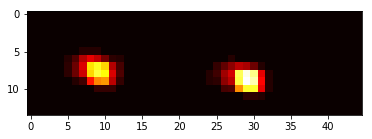

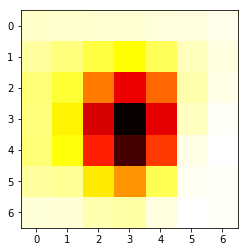

In [150]:
plt.imshow(hm[2][:,:,1], cmap='hot', interpolation='nearest')
plt.show()

plt.imshow(vcT[1][0], cmap='hot', interpolation='nearest')
plt.show()

In [63]:
def transform_heatmap(heatmap):
    voting_rules = [dict() for vc_i in range(heatmap.shape[2])]
    rcenter = int((heatmap.shape[0]-1)/2)
    ccenter = int((heatmap.shape[1]-1)/2)
    for vc_i in range(heatmap.shape[2]):
        ri,ci = np.where(heatmap[:,:,vc_i]>0)
        for pp in zip(ri,ci):
            voting_rules[vc_i][ (pp[0]-rcenter, pp[1]-ccenter) ] = heatmap[pp[0],pp[1],vc_i]
            
    return voting_rules


def vote_for_obj(lfd, lfb, voting_rules, vc_templates):
    heat_map_min = 1/350
    hm_BG_val = np.log(heat_map_min)
    
    hh,ww = lfd.shape[0:2]
    score_map = np.zeros((hh,ww))
    score_map_loc = [[[] for wi in range(ww)] for hi in range(hh)]
    for vc_i in range(lfd.shape[2]):
        tmp_loc = [[[] for wi in range(ww)] for hi in range(hh)]
        
        rr, cc = np.where(lfb[:,:,vc_i]==1)
        for pp in zip(rr,cc):
            pp_dist = lfd[pp[0]-3:pp[0]+4,pp[1]-3:pp[1]+4, vc_i]
            score2 = (1.7*49-np.sum(pp_dist**2))/24.5
            score3 = (np.sum((pp_dist - np.ones((7,7))*1.3)**2)-np.sum((pp_dist - vc_templates[vc_i])**2))/24.5
            
            for kk in voting_rules[vc_i].keys():
                vpr = pp[0]-kk[0]
                vpc = pp[1]-kk[1]
                if vpr >= 0 and vpr < hh and vpc >= 0 and vpc < ww:
                    score1 = np.log(voting_rules[vc_i][kk]) - hm_BG_val
                    tmp_loc[vpr][vpc].append([pp[0],pp[1],np.sum([score1, score2, score3])])
                    
        for hi in range(hh):
            for wi in range(ww):
                info = np.array(tmp_loc[hi][wi])
                if info.size==0:
                    continue
                    
                nms_list = nms_help(info[:,0], info[:,1], info[:,2])
                score_map[hi, wi] += np.sum(info[nms_list, 2])
                score_map_loc[hi][wi]+=list(info[nms_list, 0:2])
                    
    return score_map,score_map_loc


def nms_help(ri, ci, det, Astride=16, Arf=100, Apad=42):
    r_list = Astride * ri + Arf/2 - Apad
    c_list = Astride * ci + Arf/2 - Apad
    bb_loc = np.column_stack([c_list-Arf/2, r_list-Arf/2, c_list+Arf/2, r_list+Arf/2])
    bb_loc_ = np.column_stack([bb_loc, det])
    nms_list = nms(bb_loc_, 0.05)
    
    return nms_list

In [54]:
voting_r = transform_heatmap(heat_map)
print(voting_r[0])

{(0, -13): 0.0015560165975103733, (0, -12): 0.0031120331950207467, (0, -11): 0.0036307053941908715, (0, -10): 0.0031120331950207467, (0, -9): 0.0015560165975103733, (0, 12): 0.0020746887966804979, (0, 13): 0.0025933609958506223, (0, 14): 0.0036307053941908715, (0, 15): 0.0020746887966804979, (0, 16): 0.0015560165975103733, (1, -15): 0.0031120331950207467, (1, -14): 0.005705394190871369, (1, -13): 0.022302904564315353, (1, -12): 0.036307053941908717, (1, -11): 0.037863070539419084, (1, -10): 0.021784232365145227, (1, -9): 0.007261410788381743, (1, -8): 0.0046680497925311202, (1, -7): 0.0031120331950207467, (1, -6): 0.0015560165975103733, (1, 11): 0.01970954356846473, (1, 12): 0.033195020746887967, (1, 13): 0.035269709543568464, (1, 14): 0.01711618257261411, (1, 15): 0.0041493775933609959, (1, 16): 0.0015560165975103733, (2, -16): 0.0015560165975103733, (2, -15): 0.0041493775933609959, (2, -14): 0.0077800829875518673, (2, -13): 0.025414937759336099, (2, -12): 0.042012448132780086, (2, -1

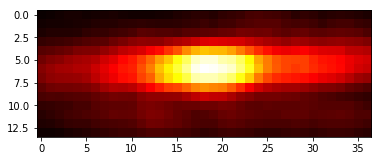

In [73]:
rst, rst_loc = vote_for_obj(layer_feature_dist[4], layer_feature_b[4], voting_r, vc_templates)
plt.imshow(rst, cmap='hot', interpolation='nearest')
plt.show()

In [74]:
rmax, cmax = np.where(rst==np.max(rst))
loc_ls = np.array(rst_loc[rmax[0]][cmax[0]])
np.min(loc_ls[:,0])-3, np.min(loc_ls[:,1])-3,np.max(loc_ls[:,0])+3, np.max(loc_ls[:,1])+3


(0.0, 0.0, 13.0, 36.0)

In [62]:
list(np.array([[1,2],[3,4]]))

[array([1, 2]), array([3, 4])]

In [47]:
from scipy.spatial.distance import pdist
pdist([[0,1],[2,3], [4,2],[9,9]])

array([  2.82842712,   4.12310563,  12.04159458,   2.23606798,
         9.21954446,   8.60232527])